In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st

In [2]:
df = pd.read_csv("datos.csv")
df.head()

,MAG,PHI,error_inf,error_sup
0,-23.183,0.000003,0.000001,0.000006
1,-23.020,0.000005,0.000003,0.000011
2,-22.870,0.000017,0.000013,0.000026
3,-22.698,0.000035,0.000025,0.000044
4,-22.565,0.000082,0.000058,0.000105


In [3]:
def schechter(M,phi0,a0,M0):
    lista = []
    for i in range(len(M)):
        p = 10**((-0.4*(M[i] - M0))*(a0 + 1))
        r = np.exp(-10**(-0.4*(M[i] -M0 )))
        y =y=0.4 * np.log(10) * phi0 * p * r
        lista.append(y)
    return(lista)

In [4]:
error_s =  df['error_sup'] - df['PHI']
error_i =  -df['error_inf'] + df['PHI']
sigma = np.abs((error_s - error_i)/2)

In [5]:
def likelihood(M,phi,phi0,a0,M0,sigma):
    phi_model = schechter(M,phi0,a0,M0) # valor de phi calculado por el modelo 
    c = 1/(np.sqrt(2*np.pi)*sigma)
    w = c*((phi - phi_model))**2/((np.sqrt(2)*sigma))**2
    p = np.sum(w)/100000000 #esto para q me queden mas chicos los valores
    return(p)

In [6]:
#fi0 = np.linspace(0.007,0.022,100)
#A0 = np.linspace(-1.80,-0.6,100)
#m0 = np.linspace(-24,-18,100)
#h = []
#for i in range(100):        
#    g = likelihood(df['MAG'],df['PHI'],fi0[i], A0[i],m0[i],sigma)
#    h.append(g)

In [7]:
#plt.plot(h,'o')

Voy a tomar los limites de los parametros como  +-%50 de los dados por Baltom 

In [38]:
philim = [-0.005,0.040]
Alim = [-2.5,0.]
Mlim = [-22,-20] # tome el %25

In [9]:
def priors(phi0,a0,m0,philim,Alim,Mlim):
    if (philim[0]<= phi0) & (phi0 <= philim[1]) & (a0 >= Alim[0]) & (a0 <= Alim[1]) & (Mlim[0]<= m0) & (Mlim[1]>= m0):
        return 1 
    else:
        return 0 

In [10]:
priors(0.1,-1.2,-21,philim,Alim,Mlim) # aca phi no pertenece

0

In [11]:
def posteriori (m,f,phi0,a0,m0,sigma,philim,Alim,Mlim): # esto es el log de la posteriori
    post = likelihood(m,f,phi0,a0,m0,sigma) + np.log(priors(phi0,a0,m0,philim,Alim,Mlim))
    return (post)

In [12]:
posteriori (df['MAG'],df['PHI'],0.0146,-1.2,-20.83,sigma,philim,Alim,Mlim)

19.80043411584049

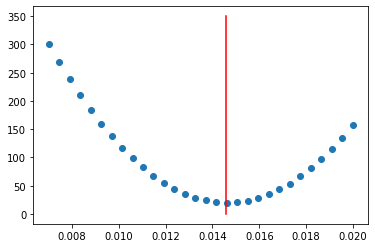

In [13]:
f0 = np.linspace(0.007,0.020,30)
a =[]
for i in range(30):
    a.append(posteriori (df['MAG'],df['PHI'],f0[i],-1.2,-20.83,sigma,philim,Alim,Mlim))
plt.plot(f0,a,'o')
plt.plot([0.0146,0.0146], [0,350],color="red")
plt.show()

In [42]:
def metropolis(m,f,phi0,a0,m0,N,philim,Alim,Mlim,sigma): #aca los phi0,a0 y m0 son valores iniciales 
 #de donde va a comensar el algoritmo
    param = np.zeros((N,3))
    if priors(phi0,a0,m0,philim,Alim,Mlim) == 1:
        param[0][0],param[0][1],param[0][2] = phi0,a0,m0
    else:
        return ('Los parametros no estan dentro de los valores permitidos')
    poste = []
    rl = []
    for i in range(N-1):
        h = posteriori (m,f, param[i][0],param[i][1],param[i][2],sigma,philim,Alim,Mlim)
        poste.append(h)
        param[i+1][0] = param[i][0] + ((np.random.rand()*2.0)-1.0)*((philim[1]-philim[0])/50)
        param[i+1][1] = param[i][1] + ((np.random.rand()*2.0)-1.0)*((Alim[1]-Alim[0])/50)
        param[i+1][2] = param[i][2] + ((np.random.rand()*2.0)-1.0)*((Mlim[1]-Mlim[0])/50)      
        #
        if priors(param[i+1][0],param[i+1][1],param[i+1][2],philim,Alim,Mlim) == 1:
            k = posteriori (m,f, param[i+1][0],param[i+1][1],param[i+1][2],sigma,philim,Alim,Mlim)
            r = h-k
            rl.append(r)  
        #r = np.exp(r)           
            if r >= 0:
                continue #acepto derecho
            else:
                r = np.exp(r)
                random = np.random.random()
                print(r,random)
                if random < r:
                    #print('Acepta')
                    continue
                else:
                    #print('No Acepta')
                    param[i+1][0] = param[i][0] 
                    param[i+1][1] = param[i][1]
                    param[i+1][2] = param[i][2]
        else:
            param[i+1][0] = param[i][0] 
            param[i+1][1] = param[i][1]
            param[i+1][2] = param[i][2]
    return(poste,rl,param)

1.9134878001099433e-46 0.56191001555117
1.8137102927294545e-37 0.22945177996729882
1.2285046357428953e-17 0.4048697703877564
1.3117251325076247e-24 0.40184849723630844
1.749928137742228e-74 0.5370833351027304
0.13585175523907275 0.039599436689009226
0.954355797935557 0.7686685585678895
0.011304290105237397 0.006181083986720237
0.0016923340495670776 0.056157914797172026
2.7970100817376205e-06 0.8369817357009599
1.0888426281033566e-12 0.037869820775328966
2.937482890232367e-45 0.6328522197449759
4.1109471453982246e-12 0.8650093973959089
1.4644752753938445e-17 0.5848767994553167
1.7566987222747758e-14 0.1853356772666902
0.012971114654568247 0.8106235233451581
3.350081042983196e-06 0.9785079099614703
0.0002466830324588464 0.9864225792664123
3.957519935671506e-34 0.41850627450102573
1.2130030987324872e-12 0.42909893877465
4.50854676204187e-11 0.3773221166485704
0.003364354432366813 0.2743250285211394
5.541070498917504e-06 0.10403719810762435
2.612353779904538e-19 0.8776710497031643
7.406448

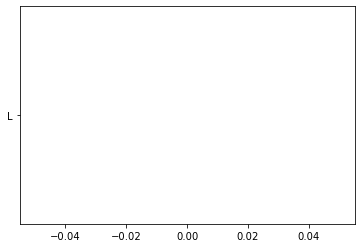

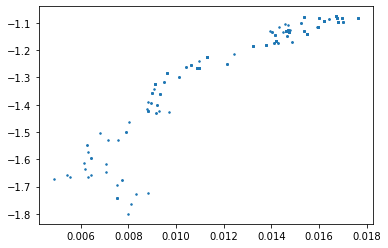

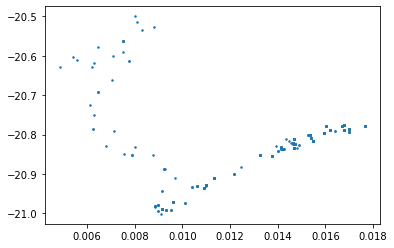

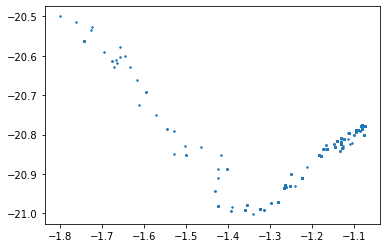

In [43]:
pos = metropolis(df['MAG'],df['PHI'],0.008,-1.8,-19,500,philim,Alim,Mlim,sigma)[0]
par = metropolis(df['MAG'],df['PHI'],0.008,-1.8,-20.5,500,philim,Alim,Mlim,sigma)[2]
plt.plot(pos,'-',lw = 3)
plt.show()
plt.plot(par[:,0],par[:,1],'.',ms = 3)
plt.show()
plt.plot(par[:,0],par[:,2],'.',ms = 3)
plt.show()
plt.plot(par[:,1],par[:,2],'.',ms = 3)
plt.show()